In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_trajectory(σ, length, T=1, x_0=5, v_0=1):
    acceleration = np.random.normal(0, σ, size=length)
    trajectory = np.ones(length) * x_0
    velocity = np.ones(length) * v_0 
    
    for i in range(1, length):
        velocity[i] = velocity[i-1] + acceleration[i-1] * T
        trajectory[i] = trajectory[i-1] + velocity[i-1] * T + (acceleration[i-1] * T ** 2) / 2 
        
    return trajectory
    
def create_measurement(σ, base_trajectory):
    measurement_noize = np.random.normal(0, σ, size=len(base_trajectory)) 
    trajectory_measured = np.copy(base_trajectory) + measurement_noize
    
    return trajectory_measured



In [3]:
size = 200 
σ_α = 0.2
σ_η = 20

trajectory = create_trajectory(σ_α, size)
measurement = create_measurement(σ_η, trajectory)

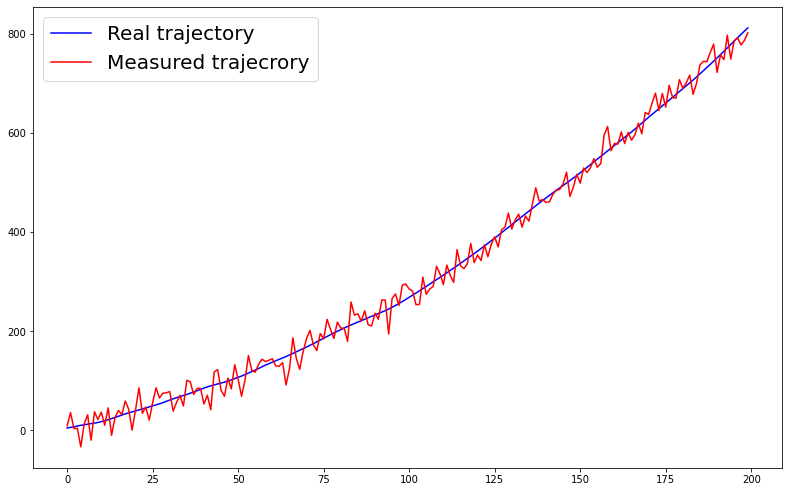

In [4]:
figure = plt.figure(figsize=[8,8])

axes = figure.add_axes([1, 1, 1.3, 0.8])

axes.plot(trajectory, "blue")
axes.plot(measurement, "red")
axes.legend(["Real trajectory", "Measured trajecrory"], fontsize=20)

plt.show()

In [5]:
# Generate a forecast vector for a base vector X using transition matrix Ф
def prediction(Φ, X):
    return np.dot(Φ, X)

def covariance_matrix_prediction(Φ, P, Q):
    return np.dot(np.dot(Φ, P), Φ.transpose()) + Q
    
# Generate a filtered vector base on forcast and mesurement
def filtration(X_forcast, measurement, K, H):
    return X_forcast + K *(measurement - np.dot(H, X_forcast))

# Get K coefficient base on observarion matrix H and covariance matrix of measurement noize R
def gain(P, H, R):
    PHt = np.dot(P, H.transpose())
    HPHt_R_1 = np.linalg.inv(np.dot(H, PHt) + R)
    return np.dot(PHt, HPHt_R_1)
                              
def covariance_matrix_filtration(K, H, P):
    I = np.eye(2)
    KH = np.dot(K, H)
    return np.dot((I - KH), P)
                              
def kalman_filter(mesurement, X_0, P_0, Φ, H, R, Q):
    X = np.ones((len(measurement),2,1))
    X_p7 = np.copy(X)
    K = np.ones((len(measurement),2,1))
    P = np.ones((len(measurement),2,2))
    X[0] = X_0
    P[0] = P_0
    Φ_7 = Φ.dot(Φ.dot(Φ.dot(Φ.dot(Φ.dot(Φ)))))
    
    for i in range(1, len(mesurement)):
        # Prediction
        P[i] = covariance_matrix_prediction(Φ, P[i-1], Q)
        X[i] = prediction(Φ, X[i-1])
        X_p7[i] = prediction(Φ_7, X[i-1])
        
        # Filtration
        K[i] = gain(P[i], H, R)
        X[i] = filtration(X[i], measurement[i], K[i], H)
        P[i] = covariance_matrix_filtration(K[i], H, P[i])
        
    return X, K, P, X_p7

In [6]:
T = 2
X_0 = np.array([[2], 
                [0]])
P_0 = np.array([[10000,0], 
                [0,10000]])
Φ = np.array([[1, T],
              [0, 1]])
H = np.array([[1, 0]])
G = np.array([[T**2],
              [T]])
R = σ_η**2
Q = np.dot(np.dot(G, G.transpose()), σ_α**2)

print(P_0)

[[10000     0]
 [    0 10000]]


In [8]:
measurement_kalman, K, P, Unused = kalman_filter(measurement, X_0, P_0, Φ, H, R, Q)

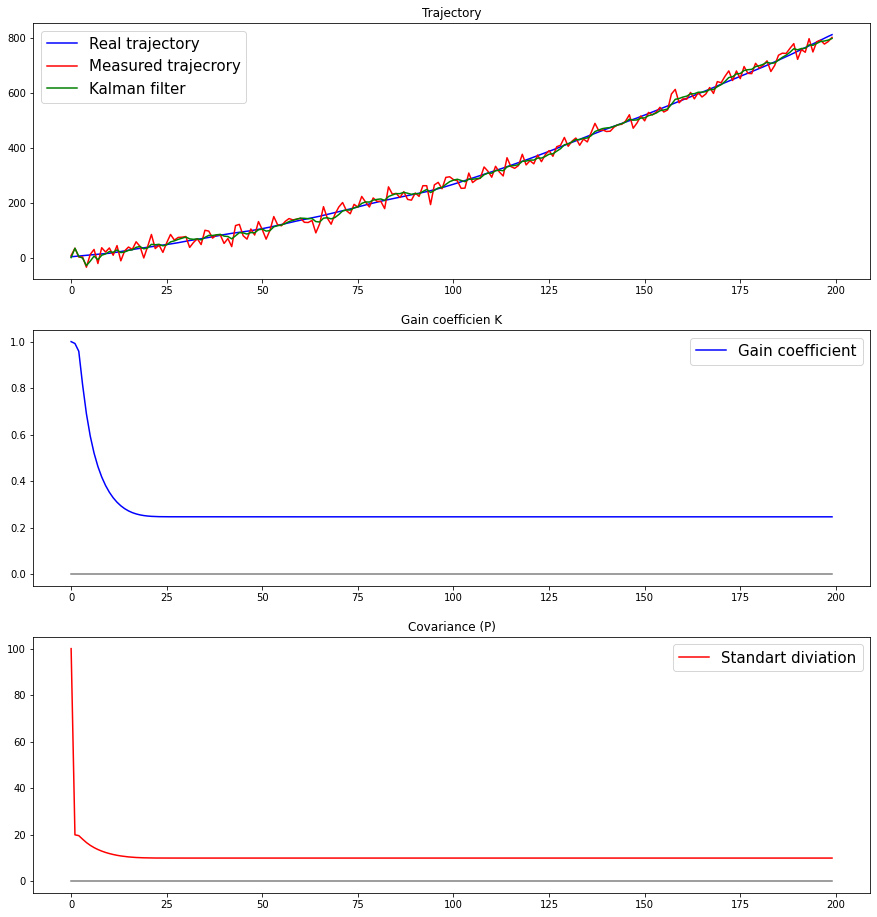

In [9]:
fig, ax = plt.subplots(nrows = 3, figsize=[15,16])

ax[0].plot(trajectory, "blue")
ax[0].plot(measurement, "red")
ax[0].plot(measurement_kalman[:,0], "green")
ax[0].legend(["Real trajectory", "Measured trajecrory", "Kalman filter"], fontsize=15)
ax[0].set(title="Trajectory")

ax[1].plot(K[:,0], "blue")
ax[1].plot(np.zeros(len(measurement)), "grey")
ax[1].legend(["Gain coefficient"], fontsize=15)
ax[1].set(title="Gain coefficien K")

ax[2].plot(P[:,0,0]**0.5, "red")
ax[2].plot(np.zeros(len(measurement)), "grey")
ax[2].legend(["Standart diviation"], fontsize=15)
ax[2].set(title="Covariance (P)")

plt.show()

# Error estimation

In [69]:
M = 500
error_kalman = np.ones(M)
error_forecast = np.ones(M)

for i in range(M):
    trajectory = create_trajectory(σ_α, size)
    measurement = create_measurement(σ_η, trajectory)
    
    X_kalman, K, P, X_forecast  = kalman_filter(measurement, X_0, P_0, Φ, H, R, Q)
    
    error_kalman[i] = np.sum(((X_kalman[:,0].transpose() - trajectory)**2)[:,2:]) / (size-3)
    error_forecast[i] = np.sum(((X_forecast[:,0].transpose() - trajectory)**2)[:,2:]) / (size-3)
    
σ_kalman = (np.sum(error_kalman[1:])/(M-1))**0.5
σ_forecast = (np.sum(error_forecast[1:])/(M-1))**0.5

print(σ_kalman, σ_forecast)

9.348524618028703 24.546539901547458
